# Data Project

Imports

In [5]:
#Imports needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Plot aesthetics (https://github.com/mcp656/Class-7/blob/main/2025%20-%20Programming%20for%20Economist/Data%20Project/Data%20Project.ipynb)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid': True, 'grid.color': 'black', 'grid.alpha': 0.25, 'grid.linestyle': '--'})
plt.rcParams.update({'font.size': 14})

#Automatically reload modules
%load_ext autoreload
%autoreload 2

import dataproject

#Packages
%pip install git+https://github.com/alemartinello/dstapi
%pip install fredapi

#APIs needed
from dstapi import DstApi
from fredapi import Fred

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/j7/ywpbgmcs3vs1q5nn2dbb4ql40000gn/T/pip-req-build-fd9t9_s0
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/j7/ywpbgmcs3vs1q5nn2dbb4ql40000gn/T/pip-req-build-fd9t9_s0
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Question 1: Aggregate Inflation in Denmark

In [6]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Aesthetics
plt.rcParams.update({
    'axes.grid': True,
    'grid.color': 'black',
    'grid.alpha': 0.25,
    'grid.linestyle': '--',
    'font.size': 13
})

from dstapi import DstApi  #Access Danmarks Statistik data

### Question 1.1: Basics

In [7]:
#1)Retrieve and check dataform DST
PRIS113 = DstApi('PRIS113')  
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [8]:
#CPI = TYPE 'INDEKS'; all months. English labels
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'TID',  'values': ['*']}
    ]
}
cpi = PRIS113.get_data(params=params).copy()

cpi = (
    cpi.rename(columns={'INDHOLD': 'P'}) #CPI level
       .assign(Time=lambda d: pd.to_datetime(d['TID'], format='%YM%m')) #monthly timestamp
       .sort_values('Time')
       .reset_index(drop=True)
)
cpi['P'] = cpi['P'].astype(float)

#Rebase CPI so the *average* of 2020 equals 100
base = cpi.loc[cpi['Time'].dt.year == 2020, 'P'].mean()
cpi['P_2020=100'] = cpi['P'] / base * 100

#Inflation rates (levels as decimals; multiply by 100 later if you want % on plots)
cpi['pi']   = cpi['P'].pct_change(1)    # month-to-month
cpi['pi12'] = cpi['P'].pct_change(12)   # 12-month

cpi = cpi.drop(columns=['TYPE', 'TID'])

#Peek
display(cpi.head())
cpi.info()

,P,Time,P_2020=100,pi,pi12
0,33.0,1980-01-01,31.904608,NaN,NaN
1,33.3,1980-02-01,32.194650,0.009091,NaN
2,33.8,1980-03-01,32.678053,0.015015,NaN
3,34.0,1980-04-01,32.871415,0.005917,NaN
4,34.5,1980-05-01,33.354818,0.014706,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   P           549 non-null    float64       
 1   Time        549 non-null    datetime64[ns]
 2   P_2020=100  549 non-null    float64       
 3   pi          548 non-null    float64       
 4   pi12        537 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 21.6 KB


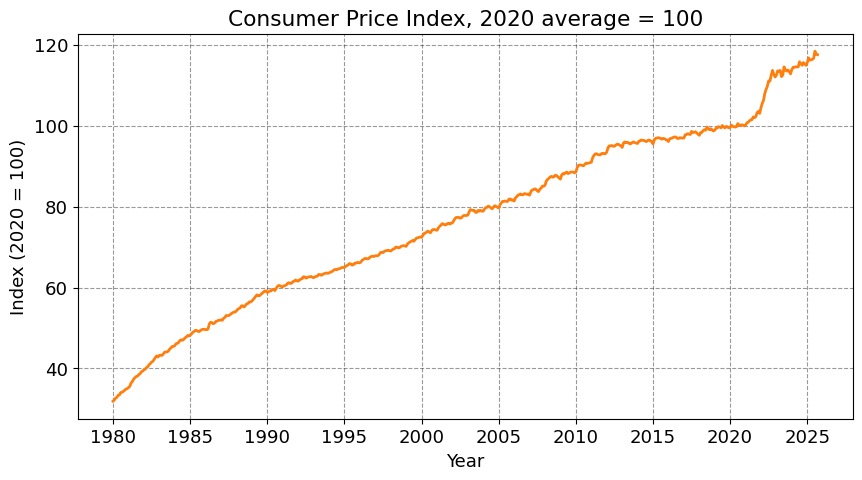

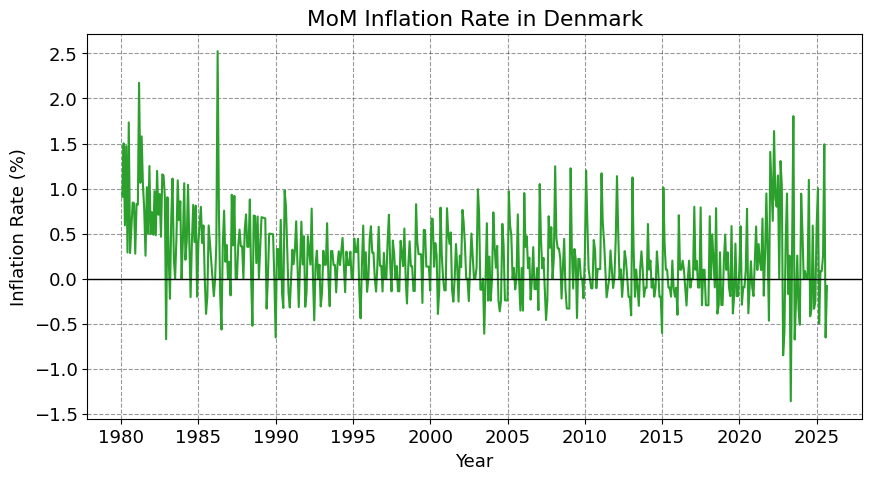

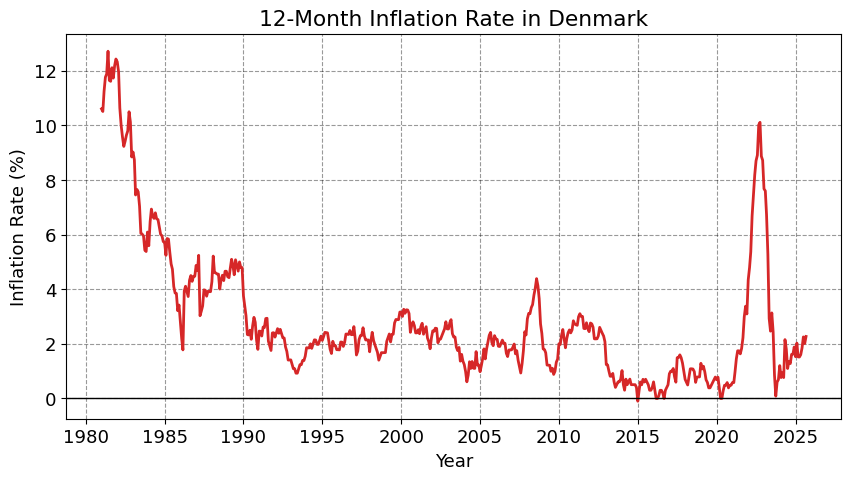

In [9]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#CPI (2020=100)
plt.figure(figsize=(10,5))
plt.plot(cpi['Time'], cpi['P_2020=100'], color=colors[1], linewidth=2)
plt.title('Consumer Price Index, 2020 average = 100')
plt.xlabel('Year')
plt.ylabel('Index (2020 = 100)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

#MoM Inflation
plt.figure(figsize=(10,5))
plt.plot(cpi['Time'], 100 * cpi['pi'], color=colors[2], linewidth=1.5)
plt.axhline(0, color='black', linewidth=1)
plt.title('MoM Inflation Rate in Denmark')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

#12-Month Inflation
plt.figure(figsize=(10,5))
plt.plot(cpi['Time'], 100 * cpi['pi12'], color=colors[3], linewidth=2)
plt.axhline(0, color='black', linewidth=1)
plt.title('12-Month Inflation Rate in Denmark')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

#### Discussion: Post-pandemic inflation
The figures above illustrate the development in the Danish Consumer Price Index (CPI) and the corresponding inflation rates.  

The CPI, indexed to an average of 100 in 2020, shows a sharp increase from 2021 to late 2022, reflecting the well-documented post-pandemic inflation surge. The month-to-month inflation rate fluctuated strongly during this period, reaching peaks of around 1 % per month in early 2022.

The 12-month inflation rate (fig. 3) peaked at roughly 10% in late 2022, before declining sharply throughout 2023. By mid-2024, the annual inflation rate had returned close to its pre-pandemic range of 1–2 %, suggesting that the inflation surge had effectively ended by that time.

Overall, the evidence points to a short-lived but pronounced inflationary episode driven by the post-COVID reopening, energy price shocks, global supply constraints and the deployment of the countercyclical capital buffer followed by a normalization in 2024.

### Question 1.2: Instantaneous Infaltion

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Defining Kappa
def kappa(alpha: int, T: int = 12):
    k = np.arange(T) #k = 0,...,T-1
    num = (T - k)**alpha
    den = np.sum((T - np.arange(T))**alpha)
    w = (num/den) * T#Sum_k w_k = T  (per definition)
    return k, w

alphas = [0, 1, 2, 3]

#Tabulating weights for a quick overview
weights_df = pd.DataFrame({f'alpha={a}': kappa(a)[1] for a in alphas},
                          index=np.arange(12))
weights_df.index.name = 'k'
display(weights_df.round(3))

#Making sure sums equal T(=12)
{k: float(weights_df[f'alpha={k}'].sum()) for k in alphas}

,alpha=0,alpha=1,alpha=2,alpha=3
k,,,,
0,1.0,1.846,2.658,3.408
1,1.0,1.692,2.234,2.625
2,1.0,1.538,1.846,1.972
3,1.0,1.385,1.495,1.438
4,1.0,1.231,1.182,1.010
5,1.0,1.077,0.905,0.677
6,1.0,0.923,0.665,0.426
7,1.0,0.769,0.462,0.247
8,1.0,0.615,0.295,0.126


{0: 12.0, 1: 12.0, 2: 12.000000000000002, 3: 12.000000000000002}

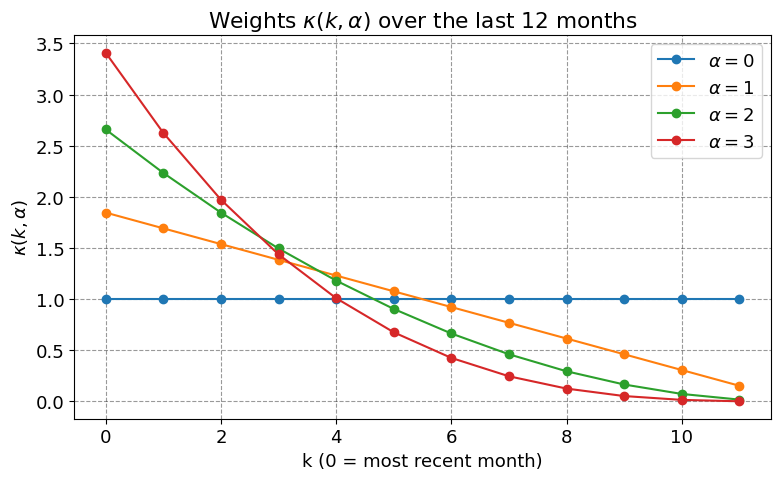

In [11]:
#Plot kappa(k, alpha)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8,5))
for i, a in enumerate(alphas):
    k, w = kappa(a)
    plt.plot(k, w, marker='o', label=fr'$\alpha={a}$', color=colors[i])
plt.title(r'Weights $\kappa(k,\alpha)$ over the last 12 months')
plt.xlabel('k (0 = most recent month)')
plt.ylabel(r'$\kappa(k,\alpha)$')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Instantaneous 12m inflation via log-sum formulation
def inst_inflation_log(window: np.ndarray, alpha: int) -> float:
    """
    Compute: prod_{k=0}^{T-1} (1+pi_{t-k})^{kappa(k,alpha)}-1
    Pandas rolling windows are ordered from oldest to newest. Our weights are recent-first,
    so we reverse weights to align with the window ordering.
    """
    T = len(window)
    _, w_recent_first = kappa(alpha, T)
    w_oldest_first = w_recent_first[::-1]
    one_plus = np.maximum(1.0 + window, 1e-12) #guarding against tiny negative values
    return float(np.exp(np.dot(w_oldest_first, np.log(one_plus))) - 1.0)


In [13]:
#Making sure MoM inflation is decimals
for a in alphas:
    cpi[f'pi12_alpha{a}'] = cpi['pi'].rolling(12).apply(
        lambda x, aa=a: inst_inflation_log(x, aa),
        raw=True
    )

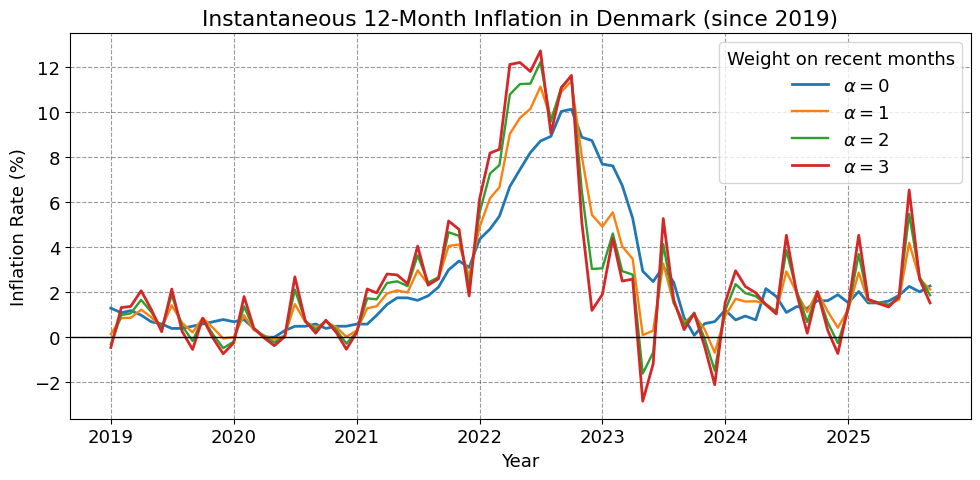

In [14]:
mask_2019 = cpi['Time'] >= pd.Timestamp('2019-01-01')

plt.figure(figsize=(10,5))
for i, a in enumerate(alphas):
    plt.plot(
        cpi.loc[mask_2019, 'Time'],
        100 * cpi.loc[mask_2019, f'pi12_alpha{a}'],
        label=fr'$\alpha={a}$',
        color=colors[i],
        linewidth=2 if a in (0,3) else 1.7
    )
plt.axhline(0, color='black', linewidth=1)
plt.title('Instantaneous 12-Month Inflation in Denmark (since 2019)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Weight on recent months')
plt.tight_layout()
plt.show()

#### Discussion: Instantaneous inflation
The first plot shows how the weights \( \kappa(k,\alpha) \) change with alpha. When alpha is 0, each of the past 12 months receives equal weight, which gives the standard 12-month inflation rate. As alpha increases, the most recent months get more weight, so the measure reacts faster to new price movements.

Looking at the second plot, all measures peak around late 2022, but the higher-alpha series (especially alpha = 2 and alpha = 3) start to decline earlier and more sharply. This shows that when we put more weight on recent months, inflation appears to cool sooner.

### Question 1.3: Core Inflation

In [15]:
#Core inflation (PRIS111)
from dstapi import DstApi
import pandas as pd
import matplotlib.pyplot as plt

#Initialize API and set parameters
PRIS111 = DstApi("PRIS111")

params = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},
        {'code': 'ENHED',  'values': ['100']},
        {'code': 'Tid',    'values': ['*']}
    ]
}

df = PRIS111.get_data(params=params).copy()

#Cleaning and preparation
df = df.rename(columns={'INDHOLD': 'index_value'})
df['index_value'] = pd.to_numeric(df['index_value'], errors='coerce')

#Converting time variable safely (YYYYMmm to datetime)
df['TID'] = pd.to_datetime(df['TID'].astype(str).str.replace('M', '-', regex=False),
                           format='%Y-%m', errors='coerce')

#Sort for correct ordering
df = df.sort_values(['VAREGR', 'TID']).reset_index(drop=True)

In [16]:
#Compute YoY-% change (12-month inflation)
df['inflation_12m'] = df.groupby('VAREGR')['index_value'].pct_change(12) * 100

#Keeping only data since 2019
df = df[df['TID'] >= '2019-01-01'].copy()

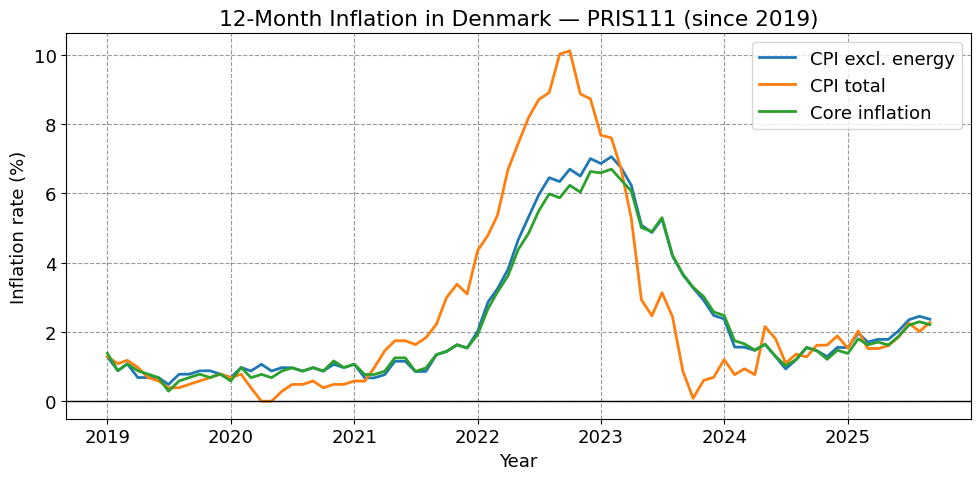

In [17]:
#Renaming series for plot labels
rename_map = {
    "00 Consumer price index, total": "CPI total",
    "15.1 Overall Consumer Price Index excl. energy": "CPI excl. energy",
    "14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)": "Core inflation"
}
df['VAREGR'] = df['VAREGR'].replace(rename_map)

#Plotting
plt.figure(figsize=(10,5))
for name, grp in df.groupby('VAREGR'):
    plt.plot(grp['TID'], grp['inflation_12m'], label=name, linewidth=2)

plt.axhline(0, color='black', lw=1)
plt.title("12-Month Inflation in Denmark — PRIS111 (since 2019)")
plt.xlabel("Year")
plt.ylabel("Inflation rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### Discussion: Core inflation
The figure compares total CPI with CPI excluding energy and core inflation (excluding both energy and unprocessed food).  
The large gap between total CPI and the other two series in 2021–2022 shows that the post-pandemic surge was mainly driven by energy and food prices. As energy prices dropped in 2023, headline inflation fell quickly, while core inflation declined more gradually.  
By mid-2024, all measures were close to pre-pandemic levels, but core inflation remained slightly higher, meaning underlying price pressures took longer to fade.

### Question 1.4: Disaggregated inflation in Denmark

In [18]:
from dstapi import DstApi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PRIS111 = DstApi('PRIS111')

# Pull variable levels for VAREGR (English labels)
levels = PRIS111.variable_levels('VAREGR', language='en')

#4-digit categories have 3 dots in the text label, e.g. "01.1.1.1 Rice"
four_digit = (
    levels.assign(dotcount=levels['text'].str.count(r'\.'))
          .loc[lambda d: d['dotcount'] == 3, ['id', 'text']]
          .reset_index(drop=True)
)

print(f"Found {len(four_digit)} four-digit categories.")
display(four_digit.head(12))

Found 217 four-digit categories.


,id,text
0,011110,01.1.1.1 Rice
1,011120,01.1.1.2 Flours and other cereals
2,011130,01.1.1.3 Bread
3,011140,01.1.1.4 Other bakery products
4,011150,01.1.1.5 Pizza and quiche
5,011160,01.1.1.6 Pasta products and couscous
6,011170,01.1.1.7 Breakfast cereals
7,011180,01.1.1.8 Other cereal products
8,011210,01.1.2.1 Beef and veal
9,011220,01.1.2.2 Pork


#### 1.4.2

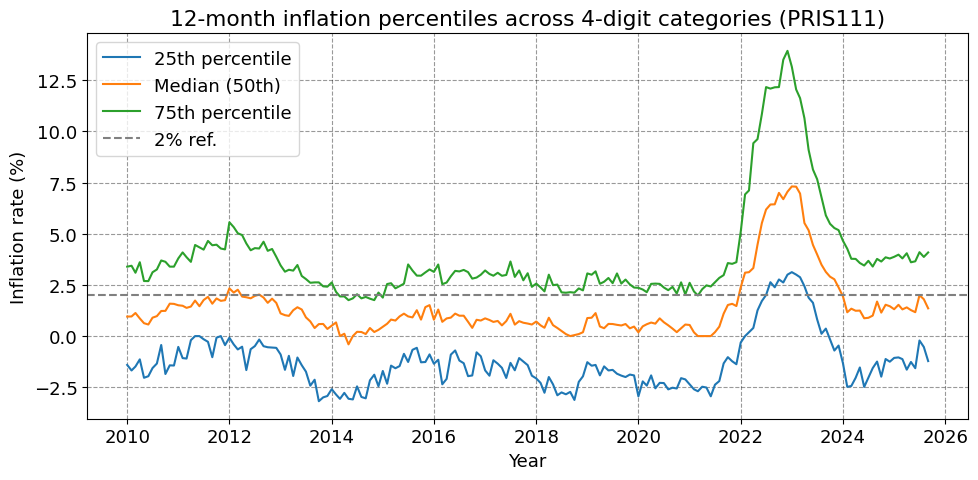

In [19]:
params_111 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': four_digit['id'].tolist()},
        {'code': 'ENHED',  'values': ['100']},    # Index (2020=100)
        {'code': 'TID',    'values': ['*']}       # All months
    ]
}
df = PRIS111.get_data(params=params_111).copy()

#Cleaning types and sort
df = (df.rename(columns={'INDHOLD': 'cpi'})
        .assign(
            cpi  = lambda d: pd.to_numeric(d['cpi'], errors='coerce'),
            date = lambda d: pd.to_datetime(d['TID'], format='%YM%m')
        )
        .dropna(subset=['cpi','date'])
        .sort_values(['VAREGR','date'])
        .reset_index(drop=True)
     )

#12-month inflation per category (percent)
df['infl_12m'] = df.groupby('VAREGR')['cpi'].pct_change(12) * 100
df_clean = df.dropna(subset=['infl_12m']).copy()

# Cross-sectional percentiles each month
percentiles = (
    df_clean.groupby('date')['infl_12m']
            .agg(p25=lambda x: x.quantile(0.25),
                 p50=lambda x: x.quantile(0.50),
                 p75=lambda x: x.quantile(0.75))
)

#Plotting percentiles
plt.figure(figsize=(10,5))
plt.plot(percentiles.index, percentiles['p25'], label='25th percentile')
plt.plot(percentiles.index, percentiles['p50'], label='Median (50th)')
plt.plot(percentiles.index, percentiles['p75'], label='75th percentile')
plt.axhline(2, color='gray', linestyle='--', label='2% ref.')
plt.title('12-month inflation percentiles across 4-digit categories (PRIS111)')
plt.xlabel('Year'); plt.ylabel('Inflation rate (%)')
plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

#### 1.4.3

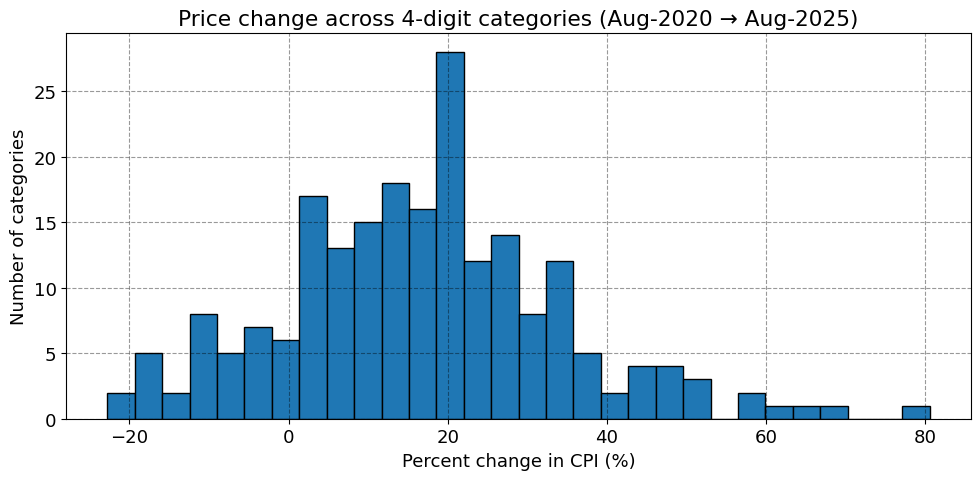

In [20]:
#Keep exactly Aug-2020 and Aug-2025
two_months = df[df['date'].isin([pd.Timestamp('2020-08-01'),
                                  pd.Timestamp('2025-08-01')])]

#Wide pivot: one row per category, columns are the two dates
w = (two_months.pivot(index='VAREGR', columns='date', values='cpi')
                 .dropna())

#5-year percent change
w['pct_change_5y'] = (w[pd.Timestamp('2025-08-01')] /
                      w[pd.Timestamp('2020-08-01')] - 1) * 100

plt.figure(figsize=(10,5))
plt.hist(w['pct_change_5y'], bins=30, edgecolor='black')
plt.title('Price change across 4-digit categories (Aug-2020 → Aug-2025)')
plt.xlabel('Percent change in CPI (%)'); plt.ylabel('Number of categories')
plt.grid(True, linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

#### 1.4.4

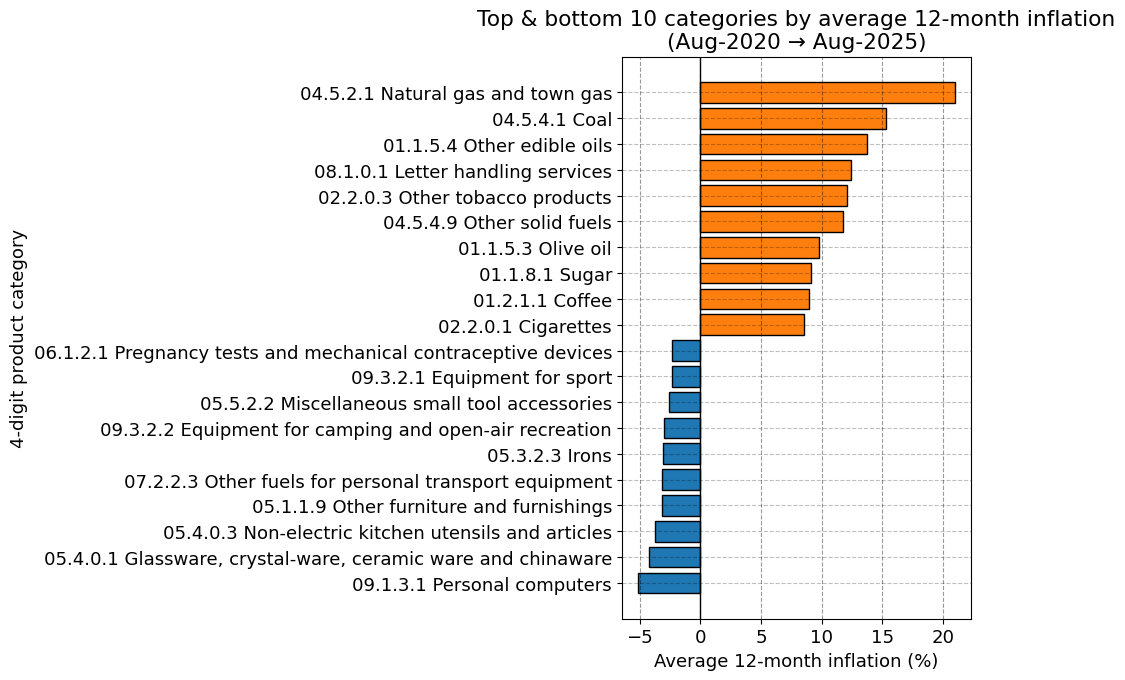

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Ensure we have 12m inflation; if not, (re)compute
if 'infl_12m' not in df.columns:
    df = df.sort_values(['VAREGR','date']).copy()
    df['infl_12m'] = df.groupby('VAREGR')['cpi'].pct_change(12) * 100

#Restrict to the evaluation window
start_win = pd.Timestamp('2020-08-01')
end_win   = pd.Timestamp('2025-08-01')
df_win = df[(df['date'] >= start_win) & (df['date'] <= end_win)].copy()

#Average 12m inflation per category over the window
avg_infl = (df_win.groupby('VAREGR', as_index=False)['infl_12m']
                 .mean()
                 .rename(columns={'infl_12m':'avg_infl_12m'}))

#Attaching readable names from four_digit (fallback to ID if missing)
name_map = dict(zip(four_digit['id'], four_digit['text']))
avg_infl['name'] = avg_infl['VAREGR'].map(name_map).fillna(avg_infl['VAREGR'])

#Extremes
top10    = avg_infl.nlargest(10, 'avg_infl_12m')
bottom10 = avg_infl.nsmallest(10, 'avg_infl_12m')

#One figure with both (bottom first so bars go up)
comb = (pd.concat([bottom10, top10], axis=0)
          .sort_values('avg_infl_12m'))

#Plot
plt.figure(figsize=(10,7))
colors = np.where(comb['avg_infl_12m'] >= 0, 'tab:orange', 'tab:blue')
plt.barh(comb['name'], comb['avg_infl_12m'], color=colors, edgecolor='black')
plt.axvline(0, color='black', lw=1)
plt.title('Top & bottom 10 categories by average 12-month inflation\n(Aug-2020 → Aug-2025)')
plt.xlabel('Average 12-month inflation (%)')
plt.ylabel('4-digit product category')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Question 2

### Question 2.1: CPI vs HICP

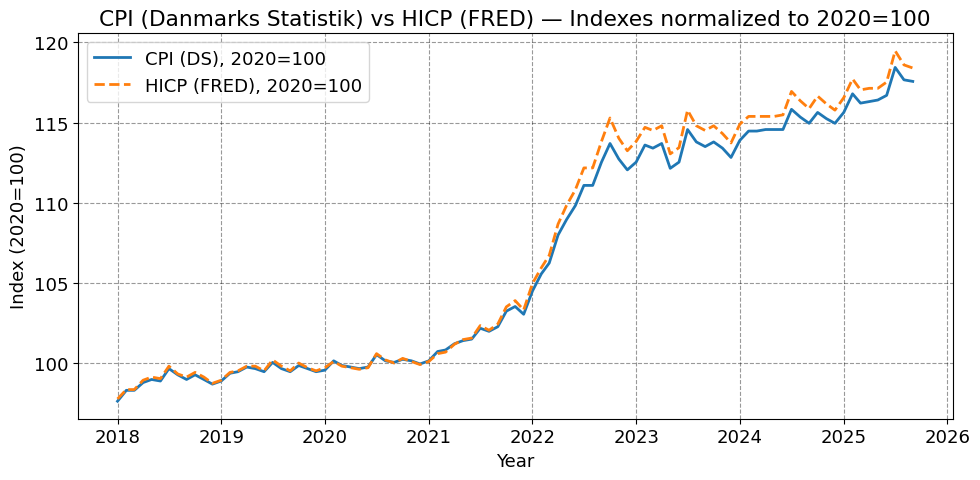

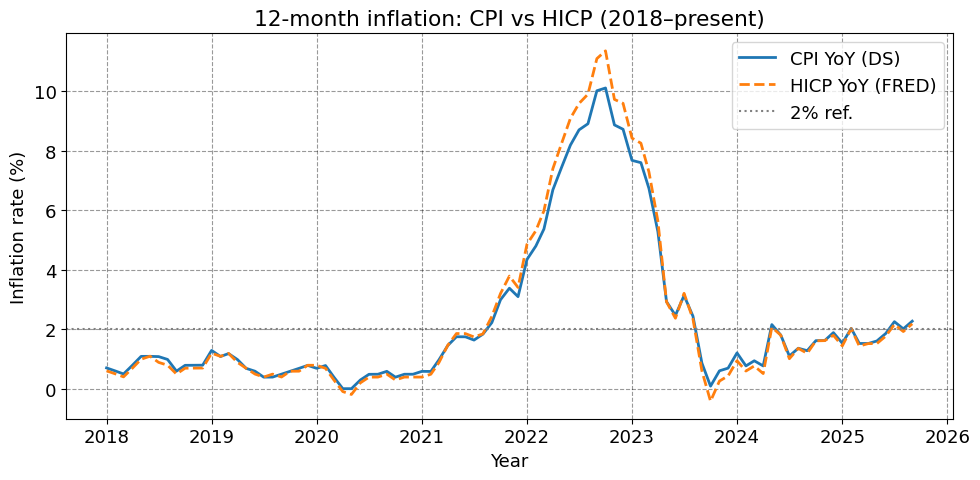

Correlation (YoY): 0.999
Mean absolute difference (YoY): 0.22 percentage points


In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dstapi import DstApi
from fredapi import Fred

#CPI from Statistics Denmark (PRIS113)
PRIS113 = DstApi('PRIS113')
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'TID',  'values': ['*']}
    ]
}
cpi = PRIS113.get_data(params=params).copy()
cpi = (cpi.rename(columns={'INDHOLD':'cpi_index', 'TID':'date'})
          .assign(
              cpi_index=lambda d: pd.to_numeric(d['cpi_index'], errors='coerce'),
              date     =lambda d: pd.to_datetime(d['date'], format='%YM%m')
          )
          .set_index('date')
          .sort_index()
       )

#Convenience: CPI YoY (%)
cpi['cpi_yoy'] = cpi['cpi_index'].pct_change(12) * 100

#HICP from FRED (CP0000DKM086NEST)
fred = Fred(api_key="c5a47321477ee99f273f9e43e84d4e2d")
hicp = fred.get_series('CP0000DKM086NEST').to_frame('hicp_index')
#Ensuring monthly DateTimeIndex
hicp.index = pd.to_datetime(hicp.index)
hicp = hicp.asfreq('MS')
#HICP YoY (%)
hicp['hicp_yoy'] = hicp['hicp_index'].pct_change(12) * 100

#Aligning sample (start 2018 to present)
lo, hi = pd.Timestamp('2018-01-01'), cpi.index.max()
both = (cpi.loc[lo:hi, ['cpi_index','cpi_yoy']]
          .join(hicp.loc[lo:hi, ['hicp_index','hicp_yoy']], how='inner'))

#Sanity checks
assert both['cpi_index'].median() > 50, "CPI levels look off."
assert both['hicp_index'].median() > 50, "HICP levels look off."
assert both.dropna().shape[0] > 24, "Very short overlap; check downloads."

#Normalizing indexes to 2020 average = 100 (for visual comparability)
def normalize_2020(series):
    w = series.loc['2020-01-01':'2020-12-31'].mean()
    return series / w * 100

both['cpi_norm2020']  = normalize_2020(both['cpi_index'])
both['hicp_norm2020'] = normalize_2020(both['hicp_index'])

#Plotting indexes and 12-month inflation
#Indexes, 2020 average = 100
plt.figure(figsize=(10,5))
plt.plot(both.index, both['cpi_norm2020'],  label='CPI (DS), 2020=100', linewidth=2)
plt.plot(both.index, both['hicp_norm2020'], label='HICP (FRED), 2020=100', linewidth=2, linestyle='--')
plt.title('CPI (Danmarks Statistik) vs HICP (FRED) — Indexes normalized to 2020=100')
plt.xlabel('Year'); plt.ylabel('Index (2020=100)')
plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

#Year-on-year inflation (%)
plt.figure(figsize=(10,5))
plt.plot(both.index, both['cpi_yoy'],  label='CPI YoY (DS)', linewidth=2)
plt.plot(both.index, both['hicp_yoy'], label='HICP YoY (FRED)', linewidth=2, linestyle='--')
plt.axhline(2, color='gray', linestyle=':', label='2% ref.')
plt.title('12-month inflation: CPI vs HICP (2018–present)')
plt.xlabel('Year'); plt.ylabel('Inflation rate (%)')
plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

#Simple diagnostics
stats = both[['cpi_yoy','hicp_yoy']].dropna()
corr = stats['cpi_yoy'].corr(stats['hicp_yoy'])
mad  = (stats['cpi_yoy'] - stats['hicp_yoy']).abs().mean()
print(f"Correlation (YoY): {corr:.3f}")
print(f"Mean absolute difference (YoY): {mad:.2f} percentage points")

Overall, the two indicies are quite comparable. The year-on-year inflation correlation is 0.999, and the average difference is only about 0.22 percentage points. This means CPI from Danmarks Statistik and the HICP from FRED capture the same price dynamics in practice.  

The small deviations mainly come from methodological differences: HICP excludes owner-occupied housing, while CPI includes it. Apart from that, they move nearly one-to-one, so the two measures can be considered fully comparable for analytical purposes.

#### 2.2: Across countries

Fetched Denmark: CP0000DKM086NEST
Fetched Austria: CP0000ATM086NEST
Fetched Euro Area: CP0000EZ19M086NEST
Fetched United States: CPIAUCSL


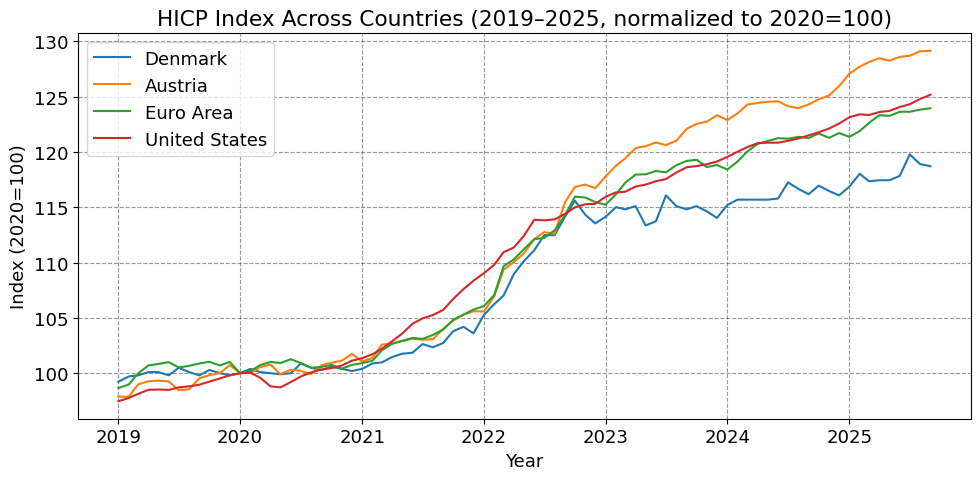

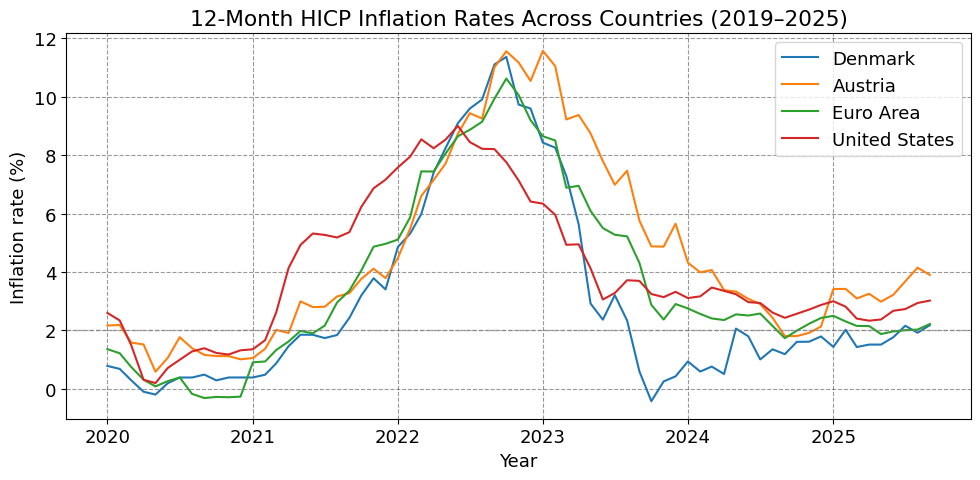


Yearly summary (min, max, mean 12-month inflation rates):


Denmark              Austria              Euro Area               \
         min    max  mean     min    max  mean       min    max  mean   
year                                                                    
2019     NaN    NaN   NaN     NaN    NaN   NaN       NaN    NaN   NaN   
2020   -0.19   0.79  0.33    0.59   2.19  1.39     -0.31   1.36  0.26   
2021    0.39   3.79  1.94    1.06   4.11  2.76      0.91   4.96  2.59   
2022    4.85  11.36  8.51    4.48  11.55  8.59      5.11  10.62  8.36   
2023   -0.42   8.43  3.44    4.87  11.57  7.78      2.37   8.64  5.46   
2024    0.51   2.06  1.27    1.81   4.32  2.93      1.74   2.75  2.36   
2025    1.43   2.18  1.77    2.98   4.15  3.46      1.88   2.50  2.14   

     United States              
               min   max  mean  
year                            
2019           NaN   NaN   NaN  
2020          0.20  2.60  1.25  
2021          1.36  7.16  4.67  
2022          6.41  9.00  8.00  
2023          3.06  6.34  4.15  
2024          2.43  3.47  2.95  
2025          2.33  3.02  2.70


Overall summary (2019–2025):


,Denmark,Austria,Euro Area,United States
min,-0.42,0.59,-0.31,0.20
max,11.36,11.57,10.62,9.00
mean,2.93,4.53,3.59,4.01


In [23]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

#Defining countries and FRED series codes (HICP / CPI All Items)
countries = {
    "Denmark": "CP0000DKM086NEST",
    "Austria": "CP0000ATM086NEST",
    "Euro Area": "CP0000EZ19M086NEST",
    "United States": "CPIAUCSL"
}

fred = Fred(api_key="c5a47321477ee99f273f9e43e84d4e2d")

#Downloading and aligning data for all countries
data = {}
for country, code in countries.items():
    series = fred.get_series(code)
    data[country] = series
    print(f"Fetched {country}: {code}")

hicp_df = pd.DataFrame(data).asfreq("MS")
hicp_df = hicp_df.loc["2019-01-01":].ffill()

#Computing 12-month inflation rates
hicp_yoy = hicp_df.pct_change(12) * 100

#Plot 1: Index levels
plt.figure(figsize=(10,5))
for col in hicp_df.columns:
    plt.plot(hicp_df.index, hicp_df[col] / hicp_df.loc["2020-01-01", col] * 100, label=col)
plt.title("HICP Index Across Countries (2019–2025, normalized to 2020=100)")
plt.ylabel("Index (2020=100)")
plt.xlabel("Year")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

#Plot 2: 12-month inflation rates
plt.figure(figsize=(10,5))
for col in hicp_yoy.columns:
    plt.plot(hicp_yoy.index, hicp_yoy[col], label=col)
plt.title("12-Month HICP Inflation Rates Across Countries (2019–2025)")
plt.ylabel("Inflation rate (%)")
plt.xlabel("Year")
plt.axhline(2, color='gray', linestyle='--', linewidth=1, alpha=0.6)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

#Summary statistics
hicp_yoy["year"] = hicp_yoy.index.year
summary_by_year = (
    hicp_yoy.groupby("year")
    .agg(["min", "max", "mean"])
    .round(2)
)
overall_summary = (
    hicp_yoy.drop(columns="year")
    .agg(["min", "max", "mean"])
    .round(2)
)

print("\nYearly summary (min, max, mean 12-month inflation rates):")
display(summary_by_year.loc[2019:])

print("\nOverall summary (2019–2025):")
display(overall_summary)


All four economies saw inflation surge sharply from 2021 to 2022 before cooling down through 2023–2024. The peak was highest in Austria (11.6%) and Denmark (11.4%), closely followed by the Euro Area (10.6%) and the U.S. (9.0%). Average inflation across the entire period (2019–2025) was 4.5% in Austria, 4.0% in the U.S., 3.6% in the Euro Area, and 2.9% in Denmark.  

The U.S. experienced an earlier spike in 2021, driven by post-pandemic reopening and fiscal stimulus, while European countries peaked later as energy prices surged in 2022. Since mid-2023, inflation has converged downward, but Denmark consistently remains the lowest, reflecting a faster stabilization of domestic prices relative to peers.

## Question 3: Extention

To extend the analysis beyond headline CPI, this section examines how inflation pressures evolved across product categories in Denmark using the detailed PRIS111 data.
The aim is to understand whether inflation was concentrated in a few sectors or widespread throughout the economy.

The diffusion/breadth graph shows the monthly share of 4-digit CPI categories with year-on-year inflation above 2% and 5%, as well as the share below 0%.
This helps illustrate how broad-based inflation became during the peak years and how quickly it normalized.

The distribution (stacked-area) graph breaks down all categories into inflation buckets (<0%, 0–2%, 2–5%, 5–10%, >10%), showing how the composition of price changes shifted over time.
This provides a fuller picture of the inflation landscape — from deflationary items to those with double-digit price increases.

In [24]:
#Setup before my two graphs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Ensuring we have a PRIS111 disaggregated df with 12m inflation
#Expected columns: ['VAREGR','TID','INDHOLD','inflation_12m']
def ensure_disagg_pris111():
    # Reuse if already built in earlier sections
    for cand in ["df_disagg", "VAREGR", "df_full", "df"]:
        if cand in globals():
            d = globals()[cand].copy()
            if "date" in d.columns and "TID" not in d.columns:
                d = d.rename(columns={"date":"TID"})
            if "inflation" in d.columns and "inflation_12m" not in d.columns:
                d = d.rename(columns={"inflation":"inflation_12m"})
            if "TID" in d.columns and not np.issubdtype(d["TID"].dtype, np.datetime64):
                d["TID"] = pd.to_datetime(d["TID"], errors="coerce")
            if "INDHOLD" in d.columns:
                d["INDHOLD"] = pd.to_numeric(d["INDHOLD"], errors="coerce")
            if "inflation_12m" not in d.columns and {"VAREGR","TID","INDHOLD"} <= set(d.columns):
                d = d.sort_values(["VAREGR","TID"])
                d["inflation_12m"] = d.groupby("VAREGR")["INDHOLD"].pct_change(12)*100
            if {"VAREGR","TID","INDHOLD","inflation_12m"} <= set(d.columns):
                return d[["VAREGR","TID","INDHOLD","inflation_12m"]].dropna(subset=["TID"])

    #Otherwise fetch minimally from PRIS111 (4-digit groups)
    from dstapi import DstApi
    PRIS111 = DstApi("PRIS111")
    levels = PRIS111.variable_levels("VAREGR", language="en")
    four_ids = levels[levels["text"].str.count(r"\.") == 3]["id"].tolist()
    params = {
        "table":"PRIS111","format":"BULK","lang":"en",
        "variables":[
            {"code":"VAREGR","values": four_ids},
            {"code":"ENHED","values":["100"]},
            {"code":"Tid","values":["*"]},
        ],
    }
    d = PRIS111.get_data(params=params)
    d["TID"] = pd.to_datetime(d["TID"], format="%YM%m", errors="coerce")
    d["INDHOLD"] = pd.to_numeric(d["INDHOLD"], errors="coerce")
    d = d.dropna(subset=["TID","INDHOLD"]).sort_values(["VAREGR","TID"])
    d["inflation_12m"] = d.groupby("VAREGR")["INDHOLD"].pct_change(12)*100
    return d

df_disagg = ensure_disagg_pris111().sort_values(["TID","VAREGR"])
df_disagg = df_disagg[df_disagg["TID"] >= pd.Timestamp("2019-01-01")]

/var/folders/j7/ywpbgmcs3vs1q5nn2dbb4ql40000gn/T/ipykernel_67018/3277878241.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["TID"] = pd.to_datetime(d["TID"], errors="coerce")


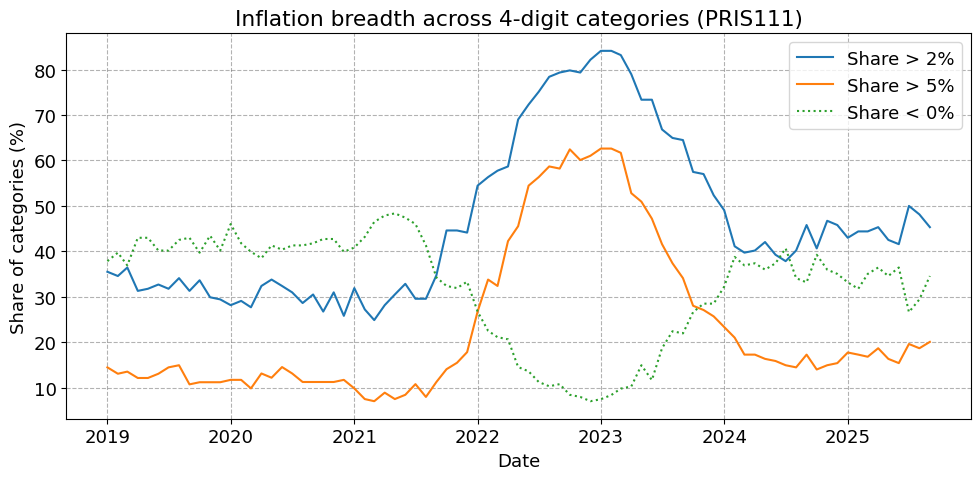

In [25]:
#Graph 1: Breath of inflation
breadth = (
    df_disagg.dropna(subset=["inflation_12m"])
             .groupby("TID")["inflation_12m"]
             .agg(
                 share_gt_2=lambda s: (s > 2).mean()*100,
                 share_gt_5=lambda s: (s > 5).mean()*100,
                 share_lt_0=lambda s: (s < 0).mean()*100,
             )
             .reset_index()
             .sort_values("TID")
)

plt.figure(figsize=(10,5))
plt.plot(breadth["TID"], breadth["share_gt_2"], label="Share > 2%")
plt.plot(breadth["TID"], breadth["share_gt_5"], label="Share > 5%")
plt.plot(breadth["TID"], breadth["share_lt_0"], label="Share < 0%", linestyle=":")
plt.title("Inflation breadth across 4-digit categories (PRIS111)")
plt.ylabel("Share of categories (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The share of items with inflation above 2% surged from roughly 30% in 2021 to over 80% in 2023, showing that nearly all product categories experienced rising prices at the peak.
The share above 5% also reached around 60%, confirming how widespread the price pressure became.
After 2023, both measures declined sharply, while deflationary items (below 0%) rose again to around 35–40%, indicating a broad disinflation phase.

/var/folders/j7/ywpbgmcs3vs1q5nn2dbb4ql40000gn/T/ipykernel_67018/1551067249.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["TID","bucket"])


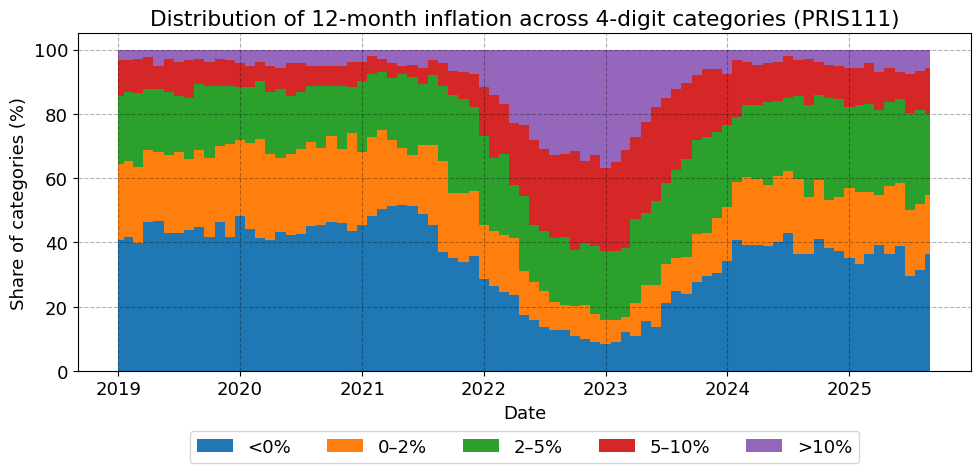

In [26]:
#Graph 2: Stacked distribution of item-leveled inflation
bins   = [-np.inf, 0, 2, 5, 10, np.inf]
labels = ["<0%", "0–2%", "2–5%", "5–10%", ">10%"]

counts = (
    df_disagg.dropna(subset=["inflation_12m"])
             .assign(bucket=lambda d: pd.cut(d["inflation_12m"], bins=bins, labels=labels))
             .groupby(["TID","bucket"])
             .size()
             .reset_index(name="n")
)
totals = counts.groupby("TID", as_index=False)["n"].sum().rename(columns={"n":"tot"})
shares = (counts.merge(totals, on="TID")
                .assign(share=lambda d: 100*d["n"]/d["tot"])
                .pivot(index="TID", columns="bucket", values="share")
                .reindex(columns=labels)    # fixed order
                .fillna(0)
                .sort_index())

plt.figure(figsize=(10,5))
plt.stackplot(shares.index, [shares[c] for c in labels], labels=labels, step="mid")
plt.title("Distribution of 12-month inflation across 4-digit categories (PRIS111)")
plt.ylabel("Share of categories (%)")
plt.xlabel("Date")
plt.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Before 2021, most prices clustered around low or negative inflation (<0% and 0–2%).
During the 2022–23 surge, the weight shifted dramatically toward higher brackets, with over 30% of categories exceeding 10% annual inflation at the peak.
By 2024–25, the distribution flattened again, with most categories returning to moderate inflation (0–5%), highlighting a clear normalization in pricing pressures across the Danish economy.

Together, the two graphs show not only that Danish inflation spiked sharply after 2021 but that it became unusually broad-based, affecting nearly all categories at once, before gradually returning to a more balanced pattern.